# Analyse de Clustering et Réduction de Dimension


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 0. CHARGEMENT DES DONNÉES


In [3]:
file_path = 'poker_dataset.csv'
df = pd.read_csv(file_path)

print("=" * 60)
print("APERÇU DES DONNÉES")
print("=" * 60)
print(f"\nDimensions du dataset : {df.shape}")
print(f"\nPremières lignes :")
display(df.head())

print(f"\nInformations sur les colonnes :")
display(df.info())

print(f"\nStatistiques descriptives :")
display(df.describe())

print(f"\nValeurs manquantes :")
display(df.isnull().sum())

APERÇU DES DONNÉES

Dimensions du dataset : (1000000, 7)

Premières lignes :


,hand,flop,result1,turn,result2,river,result3
0,♣K ♥6,♦Q ♣3 ♥3,PAIR,♦Q ♣3 ♥3 ♣7,PAIR,♦Q ♣3 ♥3 ♣7 ♣6,TWO PAIR
1,♦4 ♦3,♥5 ♣2 ♥6,STRAIGHT,♥5 ♣2 ♥6 ♥A,STRAIGHT,♥5 ♣2 ♥6 ♥A ♠Q,STRAIGHT
2,♥7 ♣5,♥A ♣6 ♥5,PAIR,♥A ♣6 ♥5 ♣7,TWO PAIR,♥A ♣6 ♥5 ♣7 ♣4,TWO PAIR
3,♠2 ♣J,♥10 ♠A ♠9,NOTHING,♥10 ♠A ♠9 ♦4,NOTHING,♥10 ♠A ♠9 ♦4 ♦3,NOTHING
4,♠K ♥9,♥Q ♦K ♦A,PAIR,♥Q ♦K ♦A ♣8,PAIR,♥Q ♦K ♦A ♣8 ♦4,PAIR



Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   hand     1000000 non-null  object
 1   flop     1000000 non-null  object
 2   result1  1000000 non-null  object
 3   turn     1000000 non-null  object
 4   result2  1000000 non-null  object
 5   river    1000000 non-null  object
 6   result3  1000000 non-null  object
dtypes: object(7)
memory usage: 53.4+ MB


None


Statistiques descriptives :


,hand,flop,result1,turn,result2,river,result3
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000
unique,2652,132520,10,927129,10,998375,10
top,♠5 ♥8,♠4 ♠3 ♥4,NOTHING,♦A ♣7 ♦Q ♠7,PAIR,♦Q ♣6 ♣9 ♣5 ♥6,PAIR
freq,440,21,501205,5,478473,3,440508



Valeurs manquantes :


hand       0
flop       0
result1    0
turn       0
result2    0
river      0
result3    0
dtype: int64

# 1. TRAITEMENT PRÉLIMINAIRE DES DONNÉES



TRAITEMENT DES DONNÉES

Valeurs manquantes avant traitement :
Series([], dtype: int64)

Valeurs manquantes après traitement :
0

Colonnes numériques (0) : []

Colonnes catégorielles (7) : ['hand', 'flop', 'result1', 'turn', 'result2', 'river', 'result3']

hand encodé : 2652 classes uniques

flop encodé : 132520 classes uniques

result1 encodé : 10 classes uniques

turn encodé : 927129 classes uniques

result2 encodé : 10 classes uniques

river encodé : 998375 classes uniques

result3 encodé : 10 classes uniques

ANALYSE DE CORRÉLATION


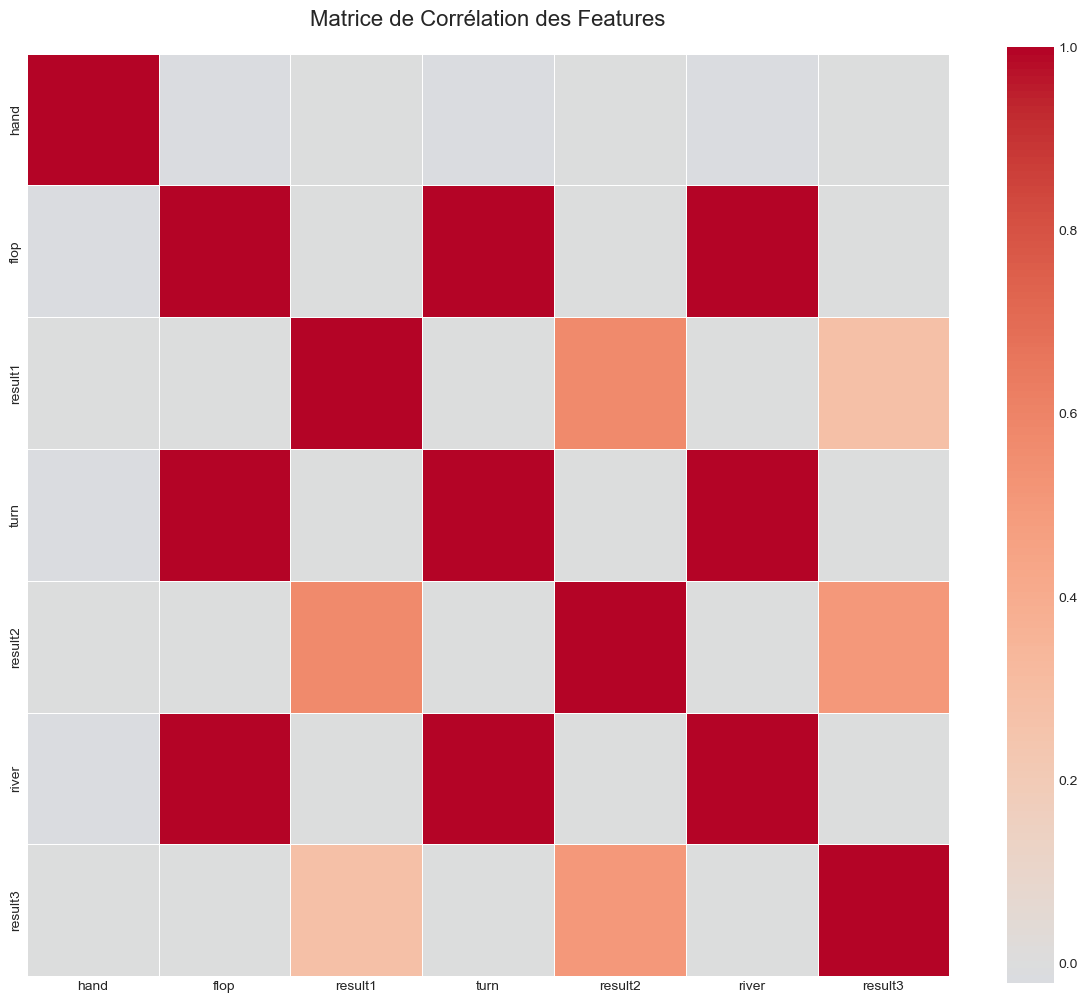


Features retenues après filtrage par variance : 7

Données normalisées : (1000000, 7)

Moyenne après normalisation (doit être ~0) : 0.000000
Écart-type après normalisation (doit être ~1) : 1.000000


In [4]:
print("\n" + "=" * 60)
print("TRAITEMENT DES DONNÉES")
print("=" * 60)

# Copie du dataframe original
df_processed = df.copy()

# Gestion des valeurs manquantes
print(f"\nValeurs manquantes avant traitement :")
print(df_processed.isnull().sum()[df_processed.isnull().sum() > 0])

# Stratégie : suppression des lignes avec trop de valeurs manquantes
threshold = 0.5  # Supprimer les lignes avec plus de 50% de valeurs manquantes
df_processed = df_processed.dropna(thresh=len(df_processed.columns) * threshold)

# Pour les colonnes numériques : imputation par la médiane
numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].median(), inplace=True)

# Pour les colonnes catégorielles : imputation par le mode
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_processed[col].isnull().sum() > 0:
        df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

print(f"\nValeurs manquantes après traitement :")
print(df_processed.isnull().sum().sum())

# Séparation des colonnes numériques et catégorielles
numeric_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()

print(f"\nColonnes numériques ({len(numeric_features)}) : {numeric_features}")
print(f"\nColonnes catégorielles ({len(categorical_features)}) : {categorical_features}")

# Encodage des variables catégorielles
df_encoded = df_processed.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le
    print(f"\n{col} encodé : {len(le.classes_)} classes uniques")

# Matrice de corrélation pour identifier les features importantes
print("\n" + "=" * 60)
print("ANALYSE DE CORRÉLATION")
print("=" * 60)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matrice de Corrélation des Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Sélection des features pour le clustering (exclure les colonnes avec variance nulle)
variance = df_encoded.var()
features_to_keep = variance[variance > 0].index.tolist()
print(f"\nFeatures retenues après filtrage par variance : {len(features_to_keep)}")

df_clustering = df_encoded[features_to_keep].copy()

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clustering)
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_keep)

print(f"\nDonnées normalisées : {X_scaled.shape}")
print(f"\nMoyenne après normalisation (doit être ~0) : {X_scaled.mean():.6f}")
print(f"Écart-type après normalisation (doit être ~1) : {X_scaled.std():.6f}")

# 2. ANALYSE K-MEANS - DÉTERMINATION DU K OPTIMAL


In [5]:
print("\n" + "=" * 60)
print("DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS")
print("=" * 60)

# Plage de k à tester
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("\nCalcul en cours...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"k={k} : Inertie={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Visualisation : Méthode du coude et Score de Silhouette
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Méthode du coude
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertie (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Méthode du Coude', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Score de Silhouette
axes[1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Nombre de clusters (k)', fontsize=12)
axes[1].set_ylabel('Score de Silhouette', fontsize=12)
axes[1].set_title('Score de Silhouette par k', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=np.mean(silhouette_scores), color='r', linestyle='--', 
                label=f'Moyenne: {np.mean(silhouette_scores):.4f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Suggestion du k optimal
best_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"\n✓ K optimal suggéré (silhouette maximale) : {best_k_silhouette}")
print(f"  Score de silhouette : {max(silhouette_scores):.4f}")

# Calcul de la dérivée seconde pour la méthode du coude
derivatives = np.diff(inertias, 2)
elbow_k = k_range[np.argmax(derivatives) + 1] if len(derivatives) > 0 else best_k_silhouette
print(f"\n✓ K suggéré (méthode du coude) : {elbow_k}")


DÉTERMINATION DU NOMBRE OPTIMAL DE CLUSTERS

Calcul en cours...


KeyboardInterrupt: 

# 3. APPLICATION DU K-MEANS AVEC K OPTIMAL


In [ ]:
print("\n" + "=" * 60)
print(f"CLUSTERING AVEC K={best_k_silhouette}")
print("=" * 60)

# K-Means final
optimal_k = best_k_silhouette  # Vous pouvez modifier cette valeur manuellement
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

# Ajout des clusters au dataframe
df_processed['Cluster'] = clusters
df_encoded['Cluster'] = clusters

# Statistiques par cluster
print(f"\nDistribution des clusters :")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
print(cluster_counts)

print(f"\nPourcentage par cluster :")
print((cluster_counts / len(clusters) * 100).round(2))

# Score de silhouette final
final_silhouette = silhouette_score(X_scaled, clusters)
print(f"\nScore de silhouette final : {final_silhouette:.4f}")


# 4. RÉDUCTION DE DIMENSION ET VISUALISATION


In [ ]:
print("\n" + "=" * 60)
print("RÉDUCTION DE DIMENSION - PCA")
print("=" * 60)

# PCA
print("\nRéduction PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_

print(f"Variance expliquée par PC1 : {explained_variance[0]:.2%}")
print(f"Variance expliquée par PC2 : {explained_variance[1]:.2%}")
print(f"Variance totale expliquée : {sum(explained_variance):.2%}")

# Projection des centres de clusters dans l'espace PCA
centers_pca = pca.transform(kmeans_final.cluster_centers_)

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. PCA avec clusters
scatter1 = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, 
                               cmap='viridis', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0, 0].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centres')
axes[0, 0].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 0].set_title('Clustering - Projection PCA', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# 2. PCA avec densité par cluster
for i in range(optimal_k):
    cluster_data = X_pca[clusters == i]
    axes[0, 1].scatter(cluster_data[:, 0], cluster_data[:, 1], 
                       label=f'Cluster {i}', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

axes[0, 1].scatter(centers_pca[:, 0], centers_pca[:, 1],
                   c='red', marker='X', s=300, edgecolors='black', linewidth=2, label='Centres', zorder=5)
axes[0, 1].set_xlabel(f'PC1 ({explained_variance[0]:.1%})', fontsize=12)
axes[0, 1].set_ylabel(f'PC2 ({explained_variance[1]:.1%})', fontsize=12)
axes[0, 1].set_title('Clustering PCA - Vue par Cluster', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Diagramme de silhouette
silhouette_vals = silhouette_samples(X_scaled, clusters)
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.viridis(float(i) / optimal_k)
    axes[1, 0].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_vals,
                              facecolor=color, edgecolor=color, alpha=0.7)
    
    axes[1, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

axes[1, 0].set_xlabel('Coefficient de Silhouette', fontsize=12)
axes[1, 0].set_ylabel('Cluster', fontsize=12)
axes[1, 0].set_title('Diagramme de Silhouette', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=final_silhouette, color='red', linestyle='--', 
                   label=f'Score moyen: {final_silhouette:.3f}')
axes[1, 0].legend()
axes[1, 0].set_xlim([-0.1, 1])
axes[1, 0].set_yticks([])
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribution des clusters
cluster_counts.plot(kind='bar', ax=axes[1, 1], color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Cluster', fontsize=12)
axes[1, 1].set_ylabel('Nombre d\'observations', fontsize=12)
axes[1, 1].set_title('Distribution des Observations par Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# 5. ANALYSE ET INTERPRÉTATION DES CLUSTERS


In [ ]:
print("\n" + "=" * 60)
print("CARACTÉRISTIQUES DES CLUSTERS")
print("=" * 60)

# Statistiques par cluster pour les features numériques
cluster_stats = df_processed.groupby('Cluster')[numeric_features].mean()

print("\nMoyennes des features numériques par cluster :")
display(cluster_stats)

# Visualisation des caractéristiques principales
if len(numeric_features) > 0:
    n_features_to_plot = min(6, len(numeric_features))
    features_to_plot = numeric_features[:n_features_to_plot]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for idx, feature in enumerate(features_to_plot):
        if idx < len(axes):
            df_processed.boxplot(column=feature, by='Cluster', ax=axes[idx])
            axes[idx].set_title(f'{feature}')
            axes[idx].set_xlabel('Cluster')
            axes[idx].set_ylabel(feature)
            plt.sca(axes[idx])
            plt.xticks(rotation=0)
    
    # Supprimer les sous-graphiques vides
    for idx in range(len(features_to_plot), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle('Distribution des Features par Cluster', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Heatmap des moyennes normalisées par cluster
cluster_stats_normalized = (cluster_stats - cluster_stats.mean()) / cluster_stats.std()

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_stats_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, linewidths=0.5, cbar_kws={'label': 'Écart à la moyenne (z-score)'})
plt.title('Profil des Clusters - Heatmap Normalisée', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# Export des résultats
print("\n" + "=" * 60)
print("EXPORT DES RÉSULTATS")
print("=" * 60)

# Sauvegarde du dataframe avec les clusters
output_file = 'resultats_clustering.csv'
df_processed.to_csv(output_file, index=False)
print(f"\n✓ Résultats sauvegardés dans : {output_file}")

# Résumé final
print("\n" + "=" * 60)
print("RÉSUMÉ DE L'ANALYSE")
print("=" * 60)
print(f"\n• Dataset : {df.shape[0]} observations, {df.shape[1]} features")
print(f"• Features utilisées pour le clustering : {len(features_to_keep)}")
print(f"• Nombre optimal de clusters : {optimal_k}")
print(f"• Score de silhouette : {final_silhouette:.4f}")
print(f"• Variance expliquée par PCA (2D) : {sum(explained_variance):.2%}")
print("\n" + "=" * 60)
print("ANALYSE TERMINÉE !")
print("=" * 60)